In [267]:
import pandas as pd
import Modelling_tools as MT
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import folium
from folium.plugins import MarkerCluster
%matplotlib inline

## Load models and determine boundaries on the hazard zone designations

In [7]:
model_SF = pickle.load(open('Model_RC_structure.sav', 'rb'))
model_EF = pickle.load(open('Model_RC_external.sav', 'rb'))
model_VF = pickle.load(open('Model_RC_vehicle.sav', 'rb'))

In [8]:
dataset = pd.read_csv("/Users/rmartinshort/Documents/Insight/Project/census_block_prediction/Fully_merged_dataset_Autogenerated_plus.csv")

In [9]:
#Do something about the NaNs
dataset['UnkownUseType'].fillna(1,inplace=True)
dataset['S'].fillna(1,inplace=True)
values = {'COMH':0, 'COMM':0, 'COMO':0, 'COMR':0, 'GOVT':0, 'IND':0, 'MISC':0,
       'MRES':0, 'SRES':0, 'A':0, 'B':0, 'C':0, 'D':0}
dataset = dataset.fillna(value=values)
dataset.fillna(dataset.mean(),inplace=True)

In [10]:
dataset.drop(['IDyear_x.1'],inplace=True,axis=1)

In [121]:
#Structural
X,y,XholdoutSF,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2018)

In [122]:
#External
X,y,XholdoutEF,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2018)

In [123]:
#Vehicle 
X,y,XholdoutVF,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2018)

In [124]:
GISCELLS = list(holdout['GISYEARJOIN'])
SF_blocks_years = gpd.read_file('SF_block_years_2010.shp')
mapdata = SF_blocks_years[SF_blocks_years['GISYEARJOI'].isin(GISCELLS)]

In [271]:
SF_2018_pred = model_SF.predict_proba(XholdoutSF)
VF_2018_pred = model_VF.predict_proba(XholdoutVF)
EF_2018_pred = model_EF.predict_proba(XholdoutEF)

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


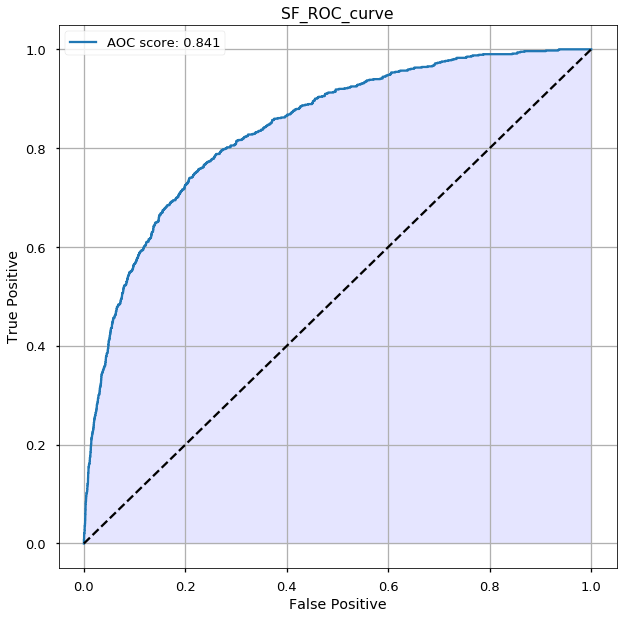

In [272]:
ROCplot, false_positive_SF, true_positive_SF, thresholds_SF = MT.plot_ROC_curve(XholdoutEF,yholdoutEF,model_EF,title='SF_ROC_curve')

In [311]:
fscoreSF = 10.0*SF_2018_pred[:,1]
fscoreVF = 10.0*VF_2018_pred[:,1]
fscoreEF = 10.0*EF_2018_pred[:,1]

In [312]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                        'fprob_VF':fscoreVF,'fprob_SF':fscoreSF})

In [313]:
## For 2018, EF

fires_2018 = pd.read_csv("2018_fires.csv")

riskmap_2018['BLOCKID'] = np.arange(len(riskmap_2018))
gdf_wgs84 = riskmap_2018.copy()
gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


m = folium.Map(location=[37.76, -122.42],zoom_start=13,
               tiles="CartoDB positron",
              width='100%',
              height='100%')
m.choropleth(geo_data=gdf_wgs84.to_json(),data=riskmap_2018,columns=['BLOCKID','fprob_EF'],
             key_on = 'feature.properties.{}'.format('BLOCKID'),
             max_zoom=16,
             fill_opacity=0.8,
             fill_color='OrRd',
             line_opacity=0.1,
             highlight=True,
             legend_name='Fire risk score')

#Add the locations of actual fires
coords = []
popups = []
icons = []
for index, row in fires_2018.iterrows():
    if row['EF'] == 1:
        lat = row['Lat']
        lon = row['Lon']
        popup = 'Lat: %.4f, Lon: %.4f' %(lat,lon)
        coords.append([lat,lon])
        popups.append(popup)
        icons.append(folium.Icon(color='white', 
                              icon_color='red', 
                              icon='fire', 
                              angle=0,
                              prefix='fa'))

plt_lyr = folium.FeatureGroup(name = 'External fires')

plt_lyr.add_children(MarkerCluster(locations = coords, popups = popups,icons = icons, overlay=True))
m.add_children(plt_lyr)

m.add_child(folium.LatLngPopup())

folium.LayerControl().add_to(m)

m.save("external_2018.html")

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [314]:
## For 2018, SF

fires_2018 = pd.read_csv("2018_fires.csv")

riskmap_2018['BLOCKID'] = np.arange(len(riskmap_2018))
gdf_wgs84 = riskmap_2018.copy()
gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


m = folium.Map(location=[37.76, -122.42],zoom_start=13,
               tiles="CartoDB positron",
              width='100%',
              height='100%')
m.choropleth(geo_data=gdf_wgs84.to_json(),data=riskmap_2018,columns=['BLOCKID','fprob_SF'],
             key_on = 'feature.properties.{}'.format('BLOCKID'),
             max_zoom=16,
             fill_opacity=0.8,
             fill_color='OrRd',
             line_opacity=0.1,
             highlight=True,
             legend_name='Fire risk score')

#Add the locations of actual fires
coords = []
popups = []
icons = []
for index, row in fires_2018.iterrows():
    if row['SF'] == 1:
        lat = row['Lat']
        lon = row['Lon']
        popup = 'Lat: %.4f, Lon: %.4f' %(lat,lon)
        coords.append([lat,lon])
        popups.append(popup)
        icons.append(folium.Icon(color='white', 
                              icon_color='red', 
                              icon='fire', 
                              angle=0,
                              prefix='fa'))

plt_lyr = folium.FeatureGroup(name = 'Structural fires')

plt_lyr.add_children(MarkerCluster(locations = coords, popups = popups,icons = icons, overlay=True))
m.add_children(plt_lyr)

m.add_child(folium.LatLngPopup())

folium.LayerControl().add_to(m)

m.save("structure_2018.html")

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [315]:
## For 2018, VF

fires_2018 = pd.read_csv("2018_fires.csv")

riskmap_2018['BLOCKID'] = np.arange(len(riskmap_2018))
gdf_wgs84 = riskmap_2018.copy()
gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


m = folium.Map(location=[37.76, -122.42],zoom_start=13,
               tiles="CartoDB positron",
              width='100%',
              height='100%')
m.choropleth(geo_data=gdf_wgs84.to_json(),data=riskmap_2018,columns=['BLOCKID','fprob_VF'],
             key_on = 'feature.properties.{}'.format('BLOCKID'),
             max_zoom=16,
             fill_opacity=0.8,
             fill_color='OrRd',
             line_opacity=0.1,
             highlight=True,
             legend_name='Fire risk score')

#Add the locations of actual fires
coords = []
popups = []
icons = []
for index, row in fires_2018.iterrows():
    if row['VF'] == 1:
        lat = row['Lat']
        lon = row['Lon']
        popup = 'Lat: %.4f, Lon: %.4f' %(lat,lon)
        coords.append([lat,lon])
        popups.append(popup)
        icons.append(folium.Icon(color='white', 
                              icon_color='red', 
                              icon='fire', 
                              angle=0,
                              prefix='fa'))

plt_lyr = folium.FeatureGroup(name = 'Vehicle fires')

plt_lyr.add_children(MarkerCluster(locations = coords, popups = popups,icons = icons, overlay=True))
m.add_children(plt_lyr)

m.add_child(folium.LatLngPopup())

folium.LayerControl().add_to(m)

m.save("vehicle_2018.html")

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### predicting 2019

In [316]:
SF_2019_pred = model_SF.predict_proba(Xuseforfuture)
VF_2019_pred = model_VF.predict_proba(Xuseforfuture)
EF_2019_pred = model_EF.predict_proba(Xuseforfuture)

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [317]:
fscoreSF = 10.0*SF_2019_pred[:,1]
fscoreVF = 10.0*VF_2019_pred[:,1]
fscoreEF = 10.0*EF_2019_pred[:,1]
riskmap_2019 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                        'fprob_VF':fscoreVF,'fprob_SF':fscoreSF})

In [318]:
## For 2019, SF

riskmap_2019['BLOCKID'] = np.arange(len(riskmap_2019))
gdf_wgs84 = riskmap_2019.copy()
gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


m = folium.Map(location=[37.76, -122.42],zoom_start=13,
               tiles="CartoDB positron",
              width='100%',
              height='100%')
m.choropleth(geo_data=gdf_wgs84.to_json(),data=riskmap_2019,columns=['BLOCKID','fprob_SF'],
             key_on = 'feature.properties.{}'.format('BLOCKID'),
             max_zoom=16,
             fill_opacity=0.8,
             fill_color='OrRd',
             line_opacity=0.1,
             highlight=True,
             legend_name='Fire risk score')

m.add_child(folium.LatLngPopup())

folium.LayerControl().add_to(m)

m.save("structure_2019.html")

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [439]:
## For 2019, VF

riskmap_2019['BLOCKID'] = np.arange(len(riskmap_2019))
gdf_wgs84 = riskmap_2019.copy()
gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


m = folium.Map(location=[37.76, -122.42],zoom_start=13,
               tiles="CartoDB positron",
              width='100%',
              height='100%')
m.choropleth(geo_data=gdf_wgs84.to_json(),data=riskmap_2019,columns=['BLOCKID','fprob_VF'],
             key_on = 'feature.properties.{}'.format('BLOCKID'),
             max_zoom=16,
             fill_opacity=0.8,
             fill_color='YlOrRd',
             line_opacity=0.1,
             highlight=True,
             legend_name='Fire risk score')

m.add_child(folium.LatLngPopup())

folium.LayerControl().add_to(m)

m.save("vehicle_2019.html")

In [438]:
## For 2019, EF

riskmap_2019['BLOCKID'] = np.arange(len(riskmap_2019))
gdf_wgs84 = riskmap_2019.copy()
gdf_wgs84.crs = {'init': 'epsg:4326', 'no_defs': True}


m = folium.Map(location=[37.76, -122.42],zoom_start=13,
               tiles="CartoDB positron",
              width='100%',
              height='100%')
m.choropleth(geo_data=gdf_wgs84.to_json(),data=riskmap_2019,columns=['BLOCKID','fprob_EF'],
             key_on = 'feature.properties.{}'.format('BLOCKID'),
             max_zoom=16,
             fill_opacity=0.8,
             fill_color='YlOrRd',
             line_opacity=0.1,
             highlight=True,
             legend_name='Fire risk score')

m.add_child(folium.LatLngPopup())

folium.LayerControl().add_to(m)

m.save("external_2019.html")

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Determine the number of fires that occur per year

In [329]:
dataset[['GISYEARJOIN','IDyear_x','EF_pred','SF_pred','VF_pred']].groupby('IDyear_x').sum().iloc[:-1].mean()

EF_pred    787.272727
SF_pred    322.636364
VF_pred    193.636364
dtype: float64

In [408]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                        'fprob_VF':fscoreVF,'fprob_SF':fscoreSF,'GISYEARJOIN':mapdata['GISYEARJOI']})

In [409]:
cells_fires_2018 = holdout[['GISYEARJOIN','Structure_fire','External_fire','Vehicle_fire','EF_pred','VF_pred','SF_pred']]

### How many external fires did we 'catch'?

In [417]:
plt.style.use('ggplot')

In [430]:
#Sort riskmap by fires
ncells = 800 #EF
EF_top_cells = riskmap_2018.sort_values(by='fprob_EF',ascending=False).iloc[:ncells]

#If a cell has fprob of greater than this value, it should be deemed high risk 
print(EF_top_cells.iloc[-1])

EF_top_cells = EF_top_cells.merge(cells_fires_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_ef_cells = EF_top_cells['EF_pred'].sum()/cells_fires_2018['EF_pred'].sum()
expected_prop_ef_cells = ncells/len(cells_fires_2018)


topcells_prev_fire = cells_fires_2018.sort_values(by='External_fire',ascending=False).iloc[:ncells]
topcells_prev_fire = topcells_prev_fire.merge(riskmap_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_ef_cells_past = topcells_prev_fire['EF_pred'].sum()/cells_fires_2018['EF_pred'].sum()

geometry       POLYGON ((-122.3951190000775 37.73731400024969...
fprob_EF                                                 1.80845
fprob_VF                                                0.716012
fprob_SF                                                0.159161
GISYEARJOIN                               G060075006120020072017
Name: 622, dtype: object


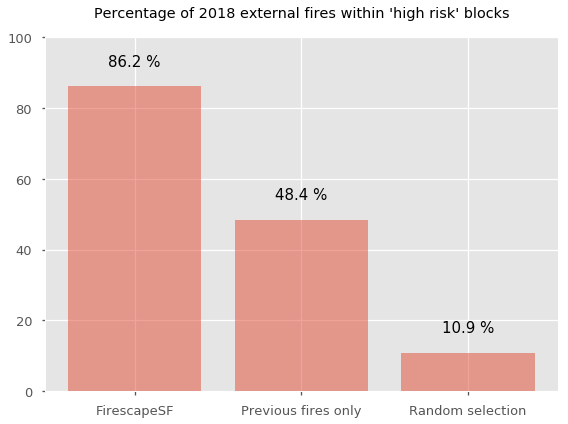

In [431]:
xlabels = ['FirescapeSF','Previous fires only','Random selection']
ylabels = [prop_ef_cells*100,prop_ef_cells_past*100,expected_prop_ef_cells*100]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
ax1.set_ylim([0,100])
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.1f %%' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=15)
ax1.set_title("Percentage of 2018 external fires within 'high risk' blocks",pad=20)
plt.tight_layout()
plt.savefig("External_fires_proportions.png",dpi=400)

### How many structure fires would we 'catch'?

In [436]:
#Sort riskmap by fires
ncells = 350 #SF
SF_top_cells = riskmap_2018.sort_values(by='fprob_SF',ascending=False).iloc[:ncells]
SF_top_cells = SF_top_cells.merge(cells_fires_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_sf_cells = SF_top_cells['SF_pred'].sum()/cells_fires_2018['SF_pred'].sum()
expected_prop_sf_cells = ncells/len(cells_fires_2018)

#If a cell has fprob of greater than this value, it should be deemed high risk 
print(SF_top_cells.iloc[-1])

topcells_prev_fire = cells_fires_2018.sort_values(by='Structure_fire',ascending=False).iloc[:ncells]
topcells_prev_fire = topcells_prev_fire.merge(riskmap_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_sf_cells_past = topcells_prev_fire['SF_pred'].sum()/cells_fires_2018['SF_pred'].sum()

geometry          POLYGON ((-122.4244119997304 37.76800600020864...
fprob_EF                                                    0.83024
fprob_VF                                                   0.197423
fprob_SF                                                   0.954163
GISYEARJOIN                                  G060075002020020032017
Structure_fire                                                    0
External_fire                                                     0
Vehicle_fire                                                      0
EF_pred                                                           0
VF_pred                                                           1
SF_pred                                                           0
Name: 349, dtype: object


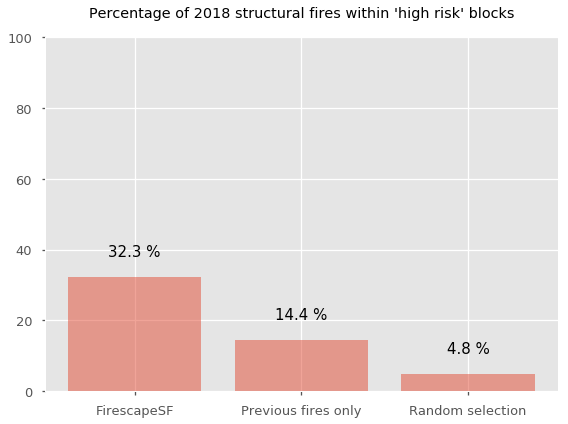

In [432]:
xlabels = ['FirescapeSF','Previous fires only','Random selection']
ylabels = [prop_sf_cells*100,prop_sf_cells_past*100,expected_prop_sf_cells*100]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
ax1.set_ylim([0,100])
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.1f %%' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=15)
ax1.set_title("Percentage of 2018 structural fires within 'high risk' blocks",pad=20)
plt.tight_layout()
plt.savefig("Structural_fires_proportions.png",dpi=400)

### How many vehicle fires would we 'catch'?

In [437]:
#Sort riskmap by fires
ncells = 200 #VF
VF_top_cells = riskmap_2018.sort_values(by='fprob_VF',ascending=False).iloc[:ncells]
VF_top_cells = VF_top_cells.merge(cells_fires_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_vf_cells = VF_top_cells['VF_pred'].sum()/cells_fires_2018['VF_pred'].sum()
expected_prop_vf_cells = ncells/len(cells_fires_2018)


#If a cell has fprob of greater than this value, it should be deemed high risk 
print(VF_top_cells.iloc[-1])

topcells_prev_fire = cells_fires_2018.sort_values(by='Vehicle_fire',ascending=False).iloc[:ncells]
topcells_prev_fire = topcells_prev_fire.merge(riskmap_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_vf_cells_past = topcells_prev_fire['VF_pred'].sum()/cells_fires_2018['VF_pred'].sum()

geometry          POLYGON ((-122.468450999854 37.76394299987275,...
fprob_EF                                                    1.96035
fprob_VF                                                   0.779643
fprob_SF                                                   0.703686
GISYEARJOIN                                  G060075003020220042017
Structure_fire                                                    1
External_fire                                                     0
Vehicle_fire                                                      0
EF_pred                                                           2
VF_pred                                                           0
SF_pred                                                           0
Name: 199, dtype: object


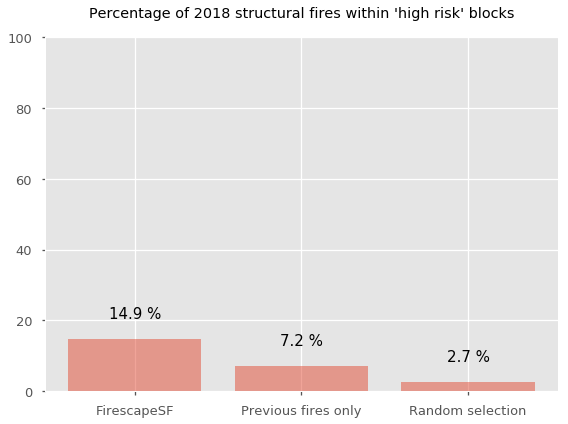

In [435]:
xlabels = ['FirescapeSF','Previous fires only','Random selection']
ylabels = [prop_vf_cells*100,prop_vf_cells_past*100,expected_prop_vf_cells*100]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
ax1.set_ylim([0,100])
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.1f %%' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=15)
ax1.set_title("Percentage of 2018 structural fires within 'high risk' blocks",pad=20)
plt.tight_layout()
plt.savefig("Vehicle_fires_proportions.png",dpi=400)